# **Balancing the Dataset**

In this step, we balance the dataset by redistributing the data across languages to achieve an equal representation for each language. This involves removing surplus entries from dominant languages (English) and translating them into other languages.

### **Step 1:  Statistical Analysis and Balancing the Dataset**

**Objective:** Balance the dataset by redistributing entries from English to other languages, ensuring equal representation.

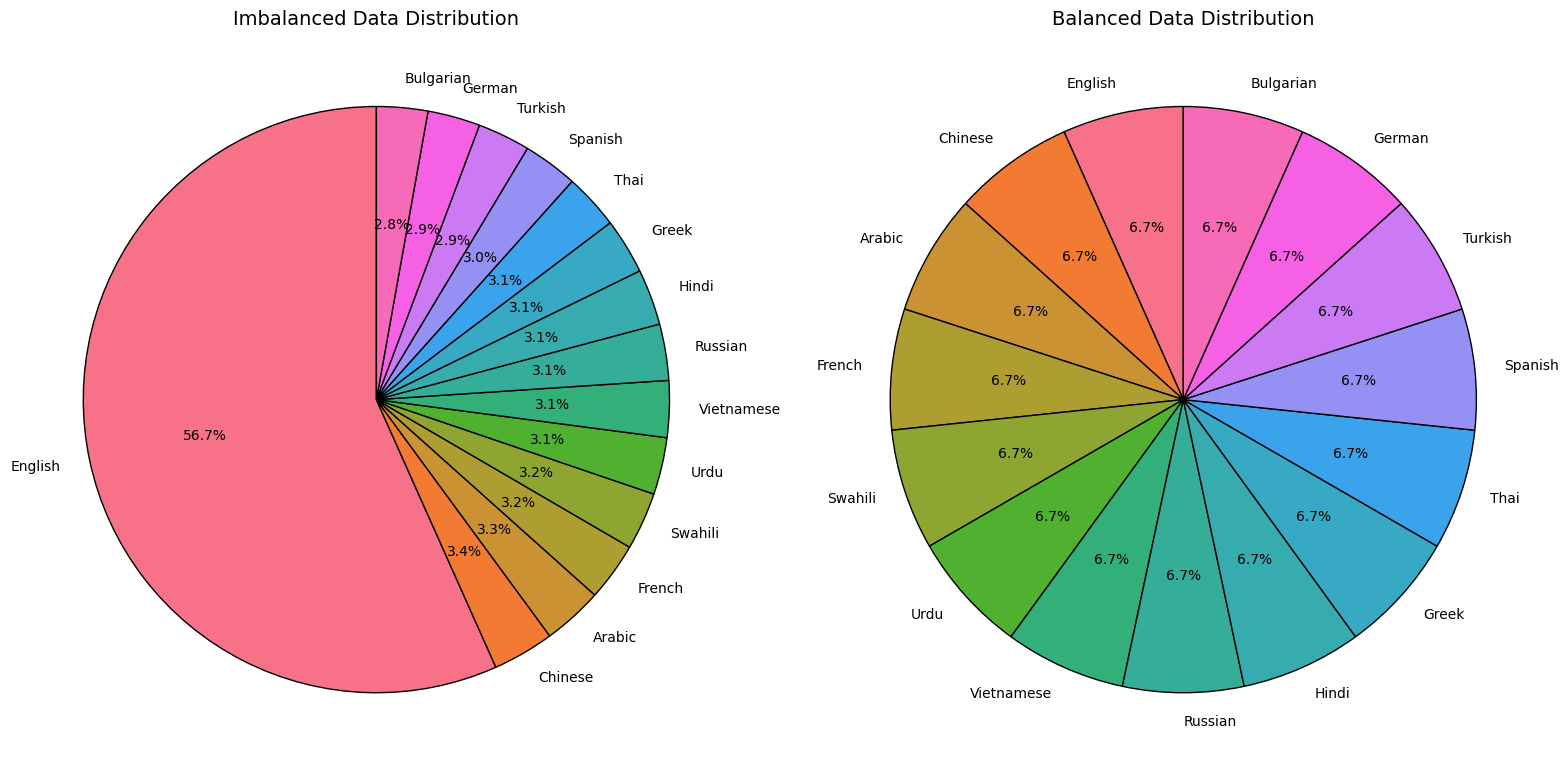

Balancing complete. Balanced datasets saved in '../data/balanced_data'.
Pie charts saved as 'data_distribution_comparison.png'.


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Directories
input_dir = "../data/language_datasets"  # Input directory containing files like "English_data.csv"
output_dir = "../data/balanced_data"  # Output directory for balanced data
os.makedirs(output_dir, exist_ok=True)

# Collect language statistics and calculate target count
language_stats = []
total_entries = 0

# Read data and collect counts
for file in os.listdir(input_dir):
    if file.endswith("_data.csv"):
        language = file.replace("_data.csv", "")
        file_path = os.path.join(input_dir, file)
        data = pd.read_csv(file_path)
        count = len(data)
        total_entries += count
        language_stats.append((language, count))

# Calculate target count per language
language_stats = sorted(language_stats, key=lambda x: x[1], reverse=True)
target_count = total_entries // len(language_stats)

# Store imbalanced stats for visualization
imbalanced_languages, imbalanced_counts = zip(*language_stats)

# Balance data
extra_entries = pd.DataFrame()  # Store leftover entries from larger datasets
balanced_stats = []

for language, count in language_stats:
    file_path = os.path.join(input_dir, f"{language}_data.csv")
    data = pd.read_csv(file_path)

    if count > target_count:
        # For languages with more data, sample down to target count
        sampled_data = data.sample(n=target_count, random_state=42)
        leftover_data = data.drop(sampled_data.index)
        extra_entries = pd.concat([extra_entries, leftover_data])
    else:
        # For languages with less data, augment from leftovers
        required = target_count - count
        augment_data = extra_entries.sample(n=required, random_state=42)
        extra_entries = extra_entries.drop(augment_data.index)
        sampled_data = pd.concat([data, augment_data])

    # Save balanced data
    balanced_file = os.path.join(output_dir, f"balanced_{language}.csv")
    sampled_data.to_csv(balanced_file, index=False)
    balanced_stats.append((language, len(sampled_data)))

# Visualization: Side-by-Side Pie Charts
balanced_languages, balanced_counts = zip(*balanced_stats)

# Generate colors using Seaborn's palette
colors = sns.color_palette("husl", len(imbalanced_languages))

# Create the subplot figure
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Imbalanced data pie chart
axes[0].pie(
    imbalanced_counts,
    labels=imbalanced_languages,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "black"}
)
axes[0].set_title("Imbalanced Data Distribution", fontsize=14)

# Balanced data pie chart
axes[1].pie(
    balanced_counts,
    labels=balanced_languages,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "black"}
)
axes[1].set_title("Balanced Data Distribution", fontsize=14)

# Adjust layout
plt.tight_layout()

# Save and show the plot
output_plot = "data_distribution_comparison.png"
plt.savefig(output_plot)
plt.show()

print(f"Balancing complete. Balanced datasets saved in '{output_dir}'.")
print(f"Pie charts saved as '{output_plot}'.")


### **Step 2: Translating English Entries**

**Objective:** 

- Translate English entries in the balanced dataset to target languages using Helsinki-NLP/opus-mt models.
- Ensure the translated dataset is cleaned by removing entries with missing or invalid text in the premise or hypothesis columns.
- Save both the cleaned dataset and problematic entries for review.

### **Why Helsinki-NLP/opus-mt:**

The Helsinki-NLP models are robust, open-source machine translation models trained on the OPUS dataset. They are designed for multilingual tasks and support a wide range of language pairs. We chose this for its:

- Wide coverage of languages.
- Fine-tuned performance for translation tasks.
- Availability in the Hugging Face Transformers library.

Despite its limitations (e.g., missing support for Thai and Turkish), it provides a reliable and scalable solution for the majority of our target languages.

In [4]:
import os
import pandas as pd
from tqdm import tqdm
from transformers import MarianMTModel, MarianTokenizer
import torch

# Paths
input_dir = "../data/balanced_data"
output_dir = "../data/translated_data"
os.makedirs(output_dir, exist_ok=True)

# Define language map for translation
language_code_map = {
    "Arabic": "ar", "Bulgarian": "bg", "Chinese": "zh", "French": "fr",
    "German": "de", "Russian": "ru", "Vietnamese": "vi", "Greek": "el",
    "Hindi": "hi", "Spanish": "es", "Swahili": "sw", "Urdu": "ur"
}

# Translation function
def translate(texts, source_lang, target_lang, batch_size=32):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_name = f"Helsinki-NLP/opus-mt-{source_lang}-{target_lang}"
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name).to(device)
    
    translations = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        outputs = model.generate(**inputs)
        translations.extend([tokenizer.decode(t, skip_special_tokens=True) for t in outputs])
    return translations

# Translate each language
for file in tqdm(os.listdir(input_dir), desc="Translating files"):
    if not file.startswith("balanced_") or not file.endswith(".csv"):
        continue

    target_language = file.replace("balanced_", "").replace(".csv", "")
    if target_language not in language_code_map:
        continue

    data = pd.read_csv(os.path.join(input_dir, file))
    english_rows = data[data["language"] == "English"]

    if english_rows.empty:
        continue

    english_rows["premise"] = translate(english_rows["premise"].tolist(), "en", language_code_map[target_language])
    english_rows["hypothesis"] = translate(english_rows["hypothesis"].tolist(), "en", language_code_map[target_language])
    english_rows["language"] = target_language

    # Combine translated data with existing language data
    combined_data = pd.concat([data[data["language"] != "English"], english_rows])
    combined_data.to_csv(os.path.join(output_dir, f"translated_{target_language}.csv"), index=False)

/home/yazata/venvs/ai_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-13 00:42:53.954807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736725373.979100  124964 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736725373.984499  124964 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 00:42:54.012148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical op

### **Step 3: Merge Files, Clean and save it into a Balanced Dataset**

**Objective:** Combine all balanced files into a single dataset and make sure all entries are valid.

In [6]:
import os
import pandas as pd

# Paths
input_dir = "../data/translated_data"  # Directory containing all translated files
output_file = "../data/train_balanced_cleaned.csv"  # Final cleaned and merged file
output_issues_file = "../data/problematic_entries.csv"  # Problematic entries for review

# Initialize lists for valid and problematic entries
all_data = []
problematic_entries = []

# Process each file in the input directory
for file in os.listdir(input_dir):
    if file.endswith(".csv"):  # Only process CSV files
        file_path = os.path.join(input_dir, file)
        print(f"Processing file: {file}")
        
        # Load the data
        data = pd.read_csv(file_path)
        
        # Check and clean each row
        for _, row in data.iterrows():
            # Ensure premise and hypothesis are strings and valid
            premise = str(row.get("premise", "")).strip()
            hypothesis = str(row.get("hypothesis", "")).strip()

            if premise and hypothesis and premise.lower() != "nan" and hypothesis.lower() != "nan":
                all_data.append(row)
            else:
                problematic_entries.append(row)

# Convert valid and problematic entries into DataFrames
valid_df = pd.DataFrame(all_data)
problematic_df = pd.DataFrame(problematic_entries)

# Shuffle the cleaned dataset
shuffled_valid_df = valid_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the cleaned and problematic datasets
shuffled_valid_df.to_csv(output_file, index=False)
problematic_df.to_csv(output_issues_file, index=False)

print(f"Final cleaned and merged dataset saved as '{output_file}'.")
print(f"Problematic entries saved as '{output_issues_file}'.")
print(f"Total valid entries: {len(shuffled_valid_df)}")
print(f"Total problematic entries: {len(problematic_df)}")

Processing file: translated_Greek.csv
Processing file: translated_German.csv
Processing file: translated_Bulgarian.csv
Processing file: translated_Swahili.csv
Processing file: translated_Turkish.csv
Processing file: translated_Spanish.csv
Processing file: translated_Urdu.csv
Processing file: translated_English.csv
Processing file: translated_Russian.csv
Processing file: translated_Arabic.csv
Processing file: translated_Chinese.csv
Processing file: translated_French.csv
Processing file: translated_Hindi.csv
Processing file: translated_Vietnamese.csv
Processing file: translated_Thai.csv
Final cleaned and merged dataset saved as '../data/train_balanced_cleaned.csv'.
Problematic entries saved as '../data/problematic_entries.csv'.
Total valid entries: 12115
Total problematic entries: 5


# **Fine-Tuning the Pre-trained Model with Balanced Dataset**
### **Step 1: Import Required Libraries**

Import necessary libraries for data handling, model setup, and training.

In [11]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

### **Step 2: Load and prepare the Dataset**

Load the raw unbalanced data and split it into train, validation, and test sets.

In [12]:
# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the raw dataset
data = pd.read_csv("../data/train_balanced_cleaned.csv")
data = data.dropna(subset=["premise", "hypothesis"])  # Drop missing entries

# Display language distribution for reference
language_counts = data["language"].value_counts()
print("Language distribution in the dataset:")
print(language_counts)

# Split the dataset (80% train, 10% validation, 10% test)
train_data, test_data = train_test_split(
    data, test_size=0.1, stratify=data["language"], random_state=123
)
train_data, val_data = train_test_split(
    train_data, test_size=0.2, stratify=train_data["language"], random_state=123
)

# Convert splits to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Combine splits into a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

Language distribution in the dataset:
language
English       811
Greek         808
Arabic        808
Spanish       808
German        808
Russian       808
Bulgarian     808
Vietnamese    808
Chinese       808
Urdu          808
Hindi         808
French        808
Swahili       808
Thai          806
Turkish       802
Name: count, dtype: int64


### **Step 3: Tokenize the Dataset**

Preprocess the dataset for the model.

In [13]:
# Specify model and load tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def preprocess_function(examples):
    return tokenizer(
        examples["premise"],
        examples["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Remove unnecessary columns
tokenized_dataset = tokenized_dataset.remove_columns(["premise", "hypothesis", "language", "lang_abv"])
print("Tokenized dataset prepared.")

Map: 100%|██████████| 1212/1212 [00:00<00:00, 6050.28 examples/s]

Tokenized dataset prepared.


### **Step 4: Define the Model and Training Arguments**

Set up the model and configure the training process.

In [14]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3  # Number of classes: entailment, neutral, contradiction
)
model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./results_{model_name.replace('/', '_')}",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir=f"./logs_{model_name.replace('/', '_')}",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Step 5: Define Evaluation Metrics**

Define the metrics to evaluate the model during training and testing.

In [15]:
# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

### **Step 6: Train and Evaluate the Model**

Initialize the trainer, train the model, and evaluate it.

In [16]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model on the test set
test_results = trainer.evaluate(tokenized_dataset["test"])
print(f"Test Results: {test_results}")

/tmp/ipykernel_124964/4245397266.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▏         | 100/5460 [00:51<46:31,  1.92it/s]

{'loss': 1.1055, 'grad_norm': 1.512783408164978, 'learning_rate': 1.9633699633699634e-05, 'epoch': 0.18}


  4%|▎         | 200/5460 [01:44<46:22,  1.89it/s]

{'loss': 1.0878, 'grad_norm': 6.621739387512207, 'learning_rate': 1.926739926739927e-05, 'epoch': 0.37}


  5%|▌         | 300/5460 [02:36<44:58,  1.91it/s]

{'loss': 1.0709, 'grad_norm': 15.541271209716797, 'learning_rate': 1.8901098901098903e-05, 'epoch': 0.55}


  7%|▋         | 400/5460 [03:29<44:24,  1.90it/s]

{'loss': 1.0583, 'grad_norm': 7.156074523925781, 'learning_rate': 1.8534798534798536e-05, 'epoch': 0.73}


  9%|▉         | 500/5460 [04:22<43:23,  1.91it/s]

{'loss': 1.0041, 'grad_norm': 49.86789321899414, 'learning_rate': 1.816849816849817e-05, 'epoch': 0.92}


                                                  
 10%|█         | 546/5460 [05:05<35:26,  2.31it/s]

{'eval_loss': 0.9434543251991272, 'eval_accuracy': 0.5529573590096286, 'eval_f1': 0.5326070496565899, 'eval_runtime': 19.7005, 'eval_samples_per_second': 110.708, 'eval_steps_per_second': 6.954, 'epoch': 1.0}


 11%|█         | 600/5460 [05:42<42:47,  1.89it/s]   

{'loss': 0.9642, 'grad_norm': 17.01106071472168, 'learning_rate': 1.78021978021978e-05, 'epoch': 1.1}


 13%|█▎        | 700/5460 [06:35<41:51,  1.90it/s]

{'loss': 0.9211, 'grad_norm': 26.2733211517334, 'learning_rate': 1.7435897435897438e-05, 'epoch': 1.28}


 15%|█▍        | 800/5460 [07:28<40:54,  1.90it/s]

{'loss': 0.8869, 'grad_norm': 17.268009185791016, 'learning_rate': 1.706959706959707e-05, 'epoch': 1.47}


 16%|█▋        | 900/5460 [08:20<40:00,  1.90it/s]

{'loss': 0.8439, 'grad_norm': 24.370285034179688, 'learning_rate': 1.6703296703296707e-05, 'epoch': 1.65}


 18%|█▊        | 1000/5460 [09:13<39:28,  1.88it/s]

{'loss': 0.8455, 'grad_norm': 21.308910369873047, 'learning_rate': 1.633699633699634e-05, 'epoch': 1.83}


                                                   
 20%|██        | 1092/5460 [10:21<31:16,  2.33it/s]

{'eval_loss': 0.8247446417808533, 'eval_accuracy': 0.6405318661164603, 'eval_f1': 0.639862708207885, 'eval_runtime': 19.8841, 'eval_samples_per_second': 109.686, 'eval_steps_per_second': 6.89, 'epoch': 2.0}


 20%|██        | 1100/5460 [10:34<1:28:34,  1.22s/it] 

{'loss': 0.8261, 'grad_norm': 18.67532730102539, 'learning_rate': 1.5970695970695972e-05, 'epoch': 2.01}


 22%|██▏       | 1200/5460 [11:27<37:24,  1.90it/s]  

{'loss': 0.7167, 'grad_norm': 36.97226333618164, 'learning_rate': 1.5604395604395605e-05, 'epoch': 2.2}


 24%|██▍       | 1300/5460 [12:20<36:39,  1.89it/s]

{'loss': 0.7165, 'grad_norm': 22.331300735473633, 'learning_rate': 1.523809523809524e-05, 'epoch': 2.38}


 26%|██▌       | 1400/5460 [13:13<35:49,  1.89it/s]

{'loss': 0.7247, 'grad_norm': 23.94695472717285, 'learning_rate': 1.4871794871794874e-05, 'epoch': 2.56}


 27%|██▋       | 1500/5460 [14:06<35:12,  1.87it/s]

{'loss': 0.7029, 'grad_norm': 19.155927658081055, 'learning_rate': 1.4505494505494506e-05, 'epoch': 2.75}


 29%|██▉       | 1600/5460 [14:59<34:14,  1.88it/s]

{'loss': 0.7064, 'grad_norm': 17.64005470275879, 'learning_rate': 1.4139194139194141e-05, 'epoch': 2.93}


                                                   
 30%|███       | 1638/5460 [15:39<27:26,  2.32it/s]

{'eval_loss': 0.8012210726737976, 'eval_accuracy': 0.6620816139385602, 'eval_f1': 0.6631478810140102, 'eval_runtime': 19.9601, 'eval_samples_per_second': 109.268, 'eval_steps_per_second': 6.864, 'epoch': 3.0}


 31%|███       | 1700/5460 [16:22<33:26,  1.87it/s]   

{'loss': 0.6077, 'grad_norm': 26.003692626953125, 'learning_rate': 1.3772893772893774e-05, 'epoch': 3.11}


 33%|███▎      | 1800/5460 [17:15<32:33,  1.87it/s]

{'loss': 0.5136, 'grad_norm': 24.681541442871094, 'learning_rate': 1.3406593406593406e-05, 'epoch': 3.3}


 35%|███▍      | 1900/5460 [18:08<31:36,  1.88it/s]

{'loss': 0.5416, 'grad_norm': 22.1431827545166, 'learning_rate': 1.3040293040293041e-05, 'epoch': 3.48}


 37%|███▋      | 2000/5460 [19:01<30:42,  1.88it/s]

{'loss': 0.5534, 'grad_norm': 19.896753311157227, 'learning_rate': 1.2673992673992674e-05, 'epoch': 3.66}


 38%|███▊      | 2100/5460 [19:54<29:41,  1.89it/s]

{'loss': 0.5127, 'grad_norm': 34.40986633300781, 'learning_rate': 1.230769230769231e-05, 'epoch': 3.85}


                                                   
 40%|████      | 2184/5460 [20:58<23:31,  2.32it/s]

{'eval_loss': 0.9290565848350525, 'eval_accuracy': 0.6579550664832645, 'eval_f1': 0.6596710463425044, 'eval_runtime': 19.8948, 'eval_samples_per_second': 109.626, 'eval_steps_per_second': 6.886, 'epoch': 4.0}


 40%|████      | 2200/5460 [21:16<30:56,  1.76it/s]  

{'loss': 0.5358, 'grad_norm': 27.270801544189453, 'learning_rate': 1.1941391941391942e-05, 'epoch': 4.03}


 42%|████▏     | 2300/5460 [22:09<27:58,  1.88it/s]

{'loss': 0.3841, 'grad_norm': 38.373374938964844, 'learning_rate': 1.1575091575091577e-05, 'epoch': 4.21}


 44%|████▍     | 2400/5460 [23:02<27:17,  1.87it/s]

{'loss': 0.3733, 'grad_norm': 60.719783782958984, 'learning_rate': 1.120879120879121e-05, 'epoch': 4.4}


 46%|████▌     | 2500/5460 [23:55<25:13,  1.96it/s]

{'loss': 0.3901, 'grad_norm': 93.16331481933594, 'learning_rate': 1.0842490842490842e-05, 'epoch': 4.58}


 48%|████▊     | 2600/5460 [24:45<23:54,  1.99it/s]

{'loss': 0.4001, 'grad_norm': 19.479997634887695, 'learning_rate': 1.0476190476190477e-05, 'epoch': 4.76}


 49%|████▉     | 2700/5460 [25:36<23:07,  1.99it/s]

{'loss': 0.3772, 'grad_norm': 28.61328125, 'learning_rate': 1.010989010989011e-05, 'epoch': 4.95}


                                                   
 50%|█████     | 2730/5460 [26:09<18:34,  2.45it/s]

{'eval_loss': 1.085168719291687, 'eval_accuracy': 0.6552040348464008, 'eval_f1': 0.6554135666348685, 'eval_runtime': 18.728, 'eval_samples_per_second': 116.457, 'eval_steps_per_second': 7.315, 'epoch': 5.0}


 51%|█████▏    | 2800/5460 [26:49<22:17,  1.99it/s]  

{'loss': 0.31, 'grad_norm': 33.8337516784668, 'learning_rate': 9.743589743589744e-06, 'epoch': 5.13}


 53%|█████▎    | 2900/5460 [27:39<21:25,  1.99it/s]

{'loss': 0.2934, 'grad_norm': 18.659425735473633, 'learning_rate': 9.377289377289379e-06, 'epoch': 5.31}


 55%|█████▍    | 3000/5460 [28:30<20:36,  1.99it/s]

{'loss': 0.26, 'grad_norm': 68.23028564453125, 'learning_rate': 9.010989010989011e-06, 'epoch': 5.49}


 57%|█████▋    | 3100/5460 [29:20<20:02,  1.96it/s]

{'loss': 0.2873, 'grad_norm': 32.89433288574219, 'learning_rate': 8.644688644688646e-06, 'epoch': 5.68}


 59%|█████▊    | 3200/5460 [30:13<19:50,  1.90it/s]

{'loss': 0.2779, 'grad_norm': 43.85271453857422, 'learning_rate': 8.278388278388278e-06, 'epoch': 5.86}


                                                   
 60%|██████    | 3276/5460 [31:12<15:43,  2.31it/s]

{'eval_loss': 1.2603942155838013, 'eval_accuracy': 0.657496561210454, 'eval_f1': 0.6577826432164535, 'eval_runtime': 19.753, 'eval_samples_per_second': 110.414, 'eval_steps_per_second': 6.936, 'epoch': 6.0}


 60%|██████    | 3300/5460 [31:34<19:05,  1.89it/s]  

{'loss': 0.2599, 'grad_norm': 21.143909454345703, 'learning_rate': 7.912087912087913e-06, 'epoch': 6.04}


 62%|██████▏   | 3400/5460 [32:26<18:01,  1.91it/s]

{'loss': 0.202, 'grad_norm': 31.534666061401367, 'learning_rate': 7.5457875457875465e-06, 'epoch': 6.23}


 64%|██████▍   | 3500/5460 [33:18<16:37,  1.96it/s]

{'loss': 0.2086, 'grad_norm': 18.58235740661621, 'learning_rate': 7.17948717948718e-06, 'epoch': 6.41}


 66%|██████▌   | 3600/5460 [34:10<15:42,  1.97it/s]

{'loss': 0.2053, 'grad_norm': 83.7120361328125, 'learning_rate': 6.813186813186814e-06, 'epoch': 6.59}


 68%|██████▊   | 3700/5460 [35:02<15:20,  1.91it/s]

{'loss': 0.2033, 'grad_norm': 51.882591247558594, 'learning_rate': 6.446886446886448e-06, 'epoch': 6.78}


 70%|██████▉   | 3800/5460 [35:55<14:31,  1.90it/s]

{'loss': 0.1586, 'grad_norm': 2.8006019592285156, 'learning_rate': 6.080586080586081e-06, 'epoch': 6.96}


                                                   
 70%|███████   | 3822/5460 [36:26<11:45,  2.32it/s]

{'eval_loss': 1.71703040599823, 'eval_accuracy': 0.6593305823016965, 'eval_f1': 0.6595530952708796, 'eval_runtime': 19.7524, 'eval_samples_per_second': 110.417, 'eval_steps_per_second': 6.936, 'epoch': 7.0}


 71%|███████▏  | 3900/5460 [37:15<13:34,  1.92it/s]  

{'loss': 0.1707, 'grad_norm': 3.772254228591919, 'learning_rate': 5.7142857142857145e-06, 'epoch': 7.14}


 73%|███████▎  | 4000/5460 [38:08<12:54,  1.89it/s]

{'loss': 0.1356, 'grad_norm': 6.263888835906982, 'learning_rate': 5.347985347985348e-06, 'epoch': 7.33}


 75%|███████▌  | 4100/5460 [39:01<11:59,  1.89it/s]

{'loss': 0.1821, 'grad_norm': 12.650520324707031, 'learning_rate': 4.9816849816849826e-06, 'epoch': 7.51}


 77%|███████▋  | 4200/5460 [39:54<11:05,  1.89it/s]

{'loss': 0.1894, 'grad_norm': 52.912620544433594, 'learning_rate': 4.615384615384616e-06, 'epoch': 7.69}


 79%|███████▉  | 4300/5460 [40:47<10:16,  1.88it/s]

{'loss': 0.1599, 'grad_norm': 11.676412582397461, 'learning_rate': 4.249084249084249e-06, 'epoch': 7.88}


                                                   
 80%|████████  | 4368/5460 [41:43<07:54,  2.30it/s]

{'eval_loss': 1.9107842445373535, 'eval_accuracy': 0.6597890875745072, 'eval_f1': 0.6611732060903422, 'eval_runtime': 20.3717, 'eval_samples_per_second': 107.06, 'eval_steps_per_second': 6.725, 'epoch': 8.0}


 81%|████████  | 4400/5460 [42:10<09:18,  1.90it/s]  

{'loss': 0.1852, 'grad_norm': 40.85694885253906, 'learning_rate': 3.882783882783883e-06, 'epoch': 8.06}


 82%|████████▏ | 4500/5460 [43:03<08:27,  1.89it/s]

{'loss': 0.1429, 'grad_norm': 33.328128814697266, 'learning_rate': 3.516483516483517e-06, 'epoch': 8.24}


 84%|████████▍ | 4600/5460 [43:56<07:36,  1.89it/s]

{'loss': 0.1321, 'grad_norm': 0.43907520174980164, 'learning_rate': 3.1501831501831505e-06, 'epoch': 8.42}


 86%|████████▌ | 4700/5460 [44:49<06:44,  1.88it/s]

{'loss': 0.1097, 'grad_norm': 73.9415512084961, 'learning_rate': 2.783882783882784e-06, 'epoch': 8.61}


 88%|████████▊ | 4800/5460 [45:42<05:47,  1.90it/s]

{'loss': 0.1337, 'grad_norm': 71.90509796142578, 'learning_rate': 2.4175824175824177e-06, 'epoch': 8.79}


 90%|████████▉ | 4900/5460 [46:36<04:56,  1.89it/s]

{'loss': 0.1081, 'grad_norm': 1.0939940214157104, 'learning_rate': 2.0512820512820513e-06, 'epoch': 8.97}


                                                   
 90%|█████████ | 4914/5460 [47:03<04:00,  2.27it/s]

{'eval_loss': 2.154171943664551, 'eval_accuracy': 0.6524530032095369, 'eval_f1': 0.6539701776046576, 'eval_runtime': 20.2861, 'eval_samples_per_second': 107.512, 'eval_steps_per_second': 6.753, 'epoch': 9.0}


 92%|█████████▏| 5000/5460 [48:01<04:03,  1.89it/s]  

{'loss': 0.1229, 'grad_norm': 0.6229479908943176, 'learning_rate': 1.6849816849816852e-06, 'epoch': 9.16}


 93%|█████████▎| 5100/5460 [48:54<03:10,  1.89it/s]

{'loss': 0.0897, 'grad_norm': 91.48078918457031, 'learning_rate': 1.3186813186813187e-06, 'epoch': 9.34}


 95%|█████████▌| 5200/5460 [49:47<02:17,  1.90it/s]

{'loss': 0.0988, 'grad_norm': 4.495588302612305, 'learning_rate': 9.523809523809525e-07, 'epoch': 9.52}


 97%|█████████▋| 5300/5460 [50:40<01:24,  1.89it/s]

{'loss': 0.0903, 'grad_norm': 55.40137481689453, 'learning_rate': 5.860805860805862e-07, 'epoch': 9.71}


 99%|█████████▉| 5400/5460 [51:33<00:31,  1.88it/s]

{'loss': 0.092, 'grad_norm': 0.8936582803726196, 'learning_rate': 2.197802197802198e-07, 'epoch': 9.89}


                                                   
100%|██████████| 5460/5460 [52:34<00:00,  2.31it/s]

{'eval_loss': 2.2135348320007324, 'eval_accuracy': 0.6529115084823476, 'eval_f1': 0.654050348248555, 'eval_runtime': 19.7469, 'eval_samples_per_second': 110.448, 'eval_steps_per_second': 6.938, 'epoch': 10.0}


100%|██████████| 5460/5460 [52:46<00:00,  1.72it/s]


{'train_runtime': 3166.3328, 'train_samples_per_second': 27.546, 'train_steps_per_second': 1.724, 'train_loss': 0.4435673548625066, 'epoch': 10.0}


100%|██████████| 76/76 [00:10<00:00,  7.09it/s]

Test Results: {'eval_loss': 0.7878903746604919, 'eval_accuracy': 0.6683168316831684, 'eval_f1': 0.6683458790583918, 'eval_runtime': 10.8631, 'eval_samples_per_second': 111.57, 'eval_steps_per_second': 6.996, 'epoch': 10.0}


### **Step 7: Save the Fine-Tuned Model**

Save the fine-tuned model and tokenizer.

In [17]:
# Save the fine-tuned model and tokenizer
output_dir = f"./fine_tuned_{model_name.replace('/', '_')}"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Fine-tuned model saved to {output_dir}")

Fine-tuned model saved to ./fine_tuned_xlm-roberta-base


### **Step 8: Analyze Results**

Save the results and plot performance.

Results saved to fine_tuning_results.csv


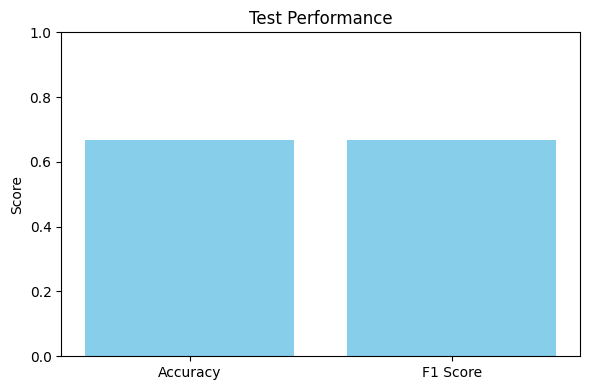

In [18]:
# Save results to a CSV file
results = [{"model": model_name, "accuracy": test_results["eval_accuracy"], "f1": test_results["eval_f1"]}]
results_df = pd.DataFrame(results)
results_filename = "fine_tuning_results.csv"
results_df.to_csv(results_filename, index=False)
print(f"Results saved to {results_filename}")

# Plot test accuracy and F1 score
plt.figure(figsize=(6, 4))
scores = [test_results["eval_accuracy"], test_results["eval_f1"]]
metrics = ["Accuracy", "F1 Score"]
plt.bar(metrics, scores, color="skyblue")
plt.title("Test Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("test_performance.png")
plt.show()

### **Step 9: Test the Best Model and Create Submission File**

Test the best fine-tuned model on the unlabeled Kaggle-provided test.csv file, make predictions, and save the results as a submission file.
The generated submission file achieved a score of 0.6947, slightly less than the score for training with imbalance data.

In [19]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

# Set device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load test data
test_data = pd.read_csv("../data/test.csv")  # Path to test data

# Load tokenizer and model
model_name = "fine_tuned_xlm-roberta-base"  # Replace with your model's directory
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()

# Preprocess test data
test_encodings = tokenizer(
    list(test_data["premise"]),
    list(test_data["hypothesis"]),
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

# Create DataLoader
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"])
test_loader = DataLoader(test_dataset, batch_size=16)  # Adjust batch size as needed

# Make predictions
predictions = []
with torch.no_grad():
    for input_ids, attention_mask in test_loader:
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(batch_predictions)

# Create submission file
submission = pd.DataFrame({"id": test_data["id"], "prediction": predictions})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv


## **Summary: Balancing the Dataset**

In this step, we balanced the dataset by **redistributing entries from the overrepresented language (English) to underrepresented languages, keeping the total dataset size constant**. Each language had 809 entries after balancing.

### **Results**

After fine-tuning the pre-trained model (xlm-roberta-base) on the balanced dataset and submitting the predictions on the unlabeled Kaggle test set, we achieved a performance score of **0.6947**, which is slightly lower than the score obtained using the imbalanced dataset (**~0.705**).

### **Analysis**

**1- Positive Impact of Balancing:**
- Balancing aimed to improve the model's performance on underrepresented languages by increasing their data points. Languages with fewer than 809 entries had their datasets expanded, potentially leading to better fine-tuning for these languages.

**2- Negative Impact on English:**
- The significant reduction of English data points (from ~6,870 to 809) likely affected the model's ability to generalize well for English. Given the substantial representation of English in the validation and test sets, this reduction may have disproportionately reduced the overall performance.

**3- Net Effect:**
- While balancing improved the representation of underrepresented languages, the drastic reduction of English entries outweighed the gains from balancing, leading to a marginally lower overall performance.

### **Next Steps**

To address these limitations, next we investigate balancing with augmentation, where additional data points are added to underrepresented languages without significantly reducing the entries for English.